# IMPORT LIBRARIES

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import label_binarize

# READ DATA

In [2]:
dfpath = '/Users/furwa/Personal/HWU/F21DL_DM&ML/Git/F21DLGroup10/F21DLGroup10'
df = pd.read_csv(os.path.join(dfpath, 'data/updated_dataset_with_3_clusters.csv'))
df.head(2)

age  sex  chest_pain_type  resting_bp  max_heart_rate  exercise_angina  \
0   40    1                2         140             172                0   
1   49    0                3         160             156                0   

   oldpeak  ST_slope  MI  cluster  
0      0.0         1   0        1  
1      1.0         2   1        1

# SPLIT DATA

In [3]:
#define X, y
df = df.drop(columns=['MI'])
X = df.drop(columns=['cluster'])  # Drop the 'MI' column to get the features
y = df['cluster']  # Set 'MI' column as the target variable

#split 1: 85%, 15% (Train+Val, Test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

#split 2: 76.5%, 23.5% (Train, Val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.235, random_state=42)

#(test, val, train: 65, 20, 15)

C:\Users\furwa\AppData\Local\Temp\ipykernel_28964\1245042871.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis", hue=None, legend=False)


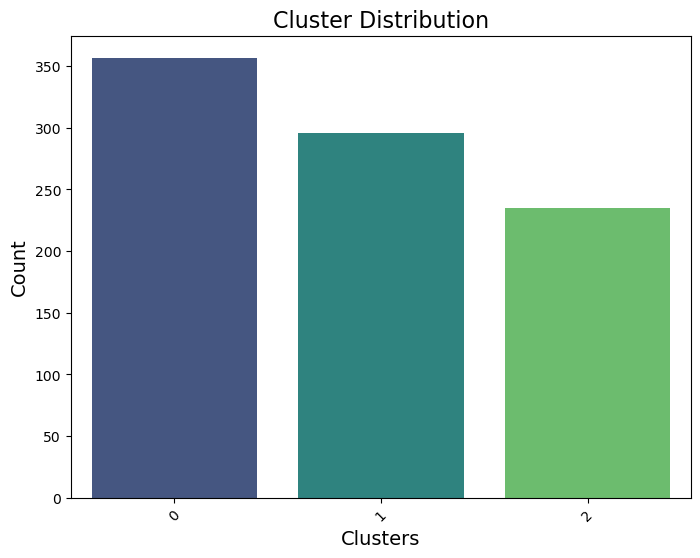

In [4]:
#cluster count
cluster_counts = df['cluster'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis", hue=None, legend=False)
plt.title('Cluster Distribution', fontsize=16)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

##class weights used instead

In [5]:
#print split size
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 576
Validation set size: 178
Test set size: 134


In [6]:
#intitialise classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

#GridSerach parameters
param_grid = {
    'n_estimators': [5, 10, 25],
    'max_depth': [3, 5, 7],
    'min_samples_split': [8, 10, 15],
    'min_samples_leaf': [10, 20, 30],
    'max_features': ['sqrt', 'log2']
}

In [7]:
#initialise GridSearch
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)



Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [10, 20, 30],
                         'min_samples_split': [8, 10, 15],
                         'n_estimators': [5, 10, 25]},
             verbose=1)

In [8]:
#save gridsearch
modelpath = os.path.join(dfpath, 'notebooks/.pkl_files/grid_search_model_tuned.pkl')
joblib.dump(grid_search, modelpath)

['/Users/furwa/Personal/HWU/F21DL_DM&ML/Git/F21DLGroup10/F21DLGroup10\\notebooks/.pkl_files/grid_search_model_tuned.pkl']

In [9]:
#get best model
best_rf = grid_search.best_estimator_
results_df = pd.DataFrame(grid_search.cv_results_)

#print results
print(best_rf)
#print best params
print("Best parameters:", grid_search.best_params_)
#print best cross-val
print("Best cross-validated score:", grid_search.best_score_)

#save best estimator
modelpath = os.path.join(dfpath, 'notebooks/.pkl_files/best_rf_model_tuned.pkl')
joblib.dump(best_rf, modelpath)

RandomForestClassifier(class_weight='balanced', max_depth=7,
                       min_samples_leaf=10, min_samples_split=8,
                       n_estimators=25, random_state=42)
Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 25}
Best cross-validated score: 0.9115547489413188


['/Users/furwa/Personal/HWU/F21DL_DM&ML/Git/F21DLGroup10/F21DLGroup10\\notebooks/.pkl_files/best_rf_model_tuned.pkl']

# VISUALISE GRIDSEARCH RESULTS

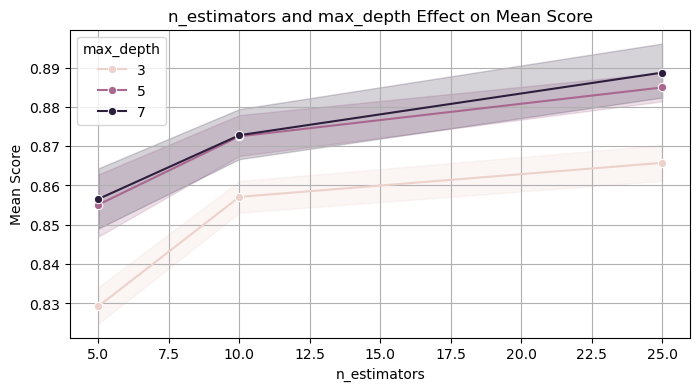

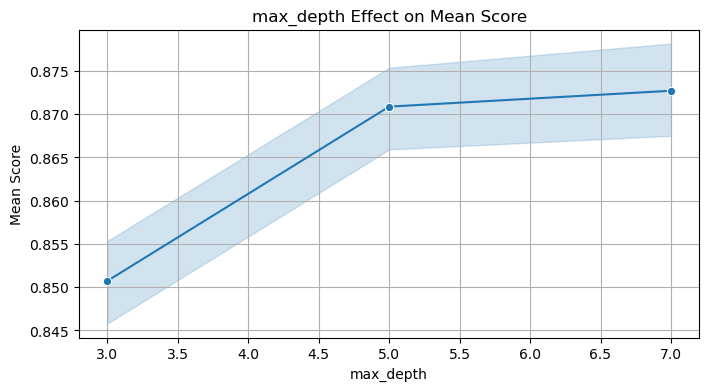

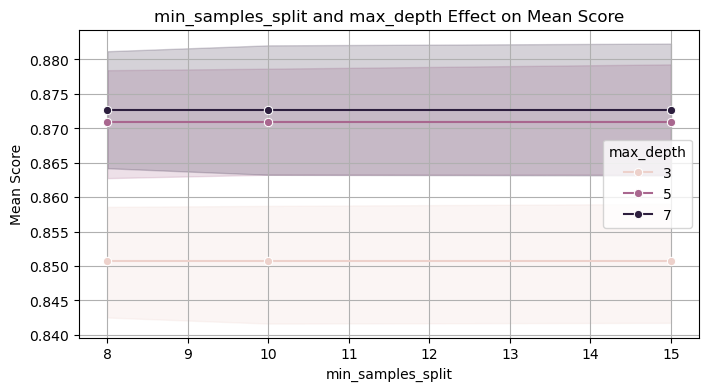

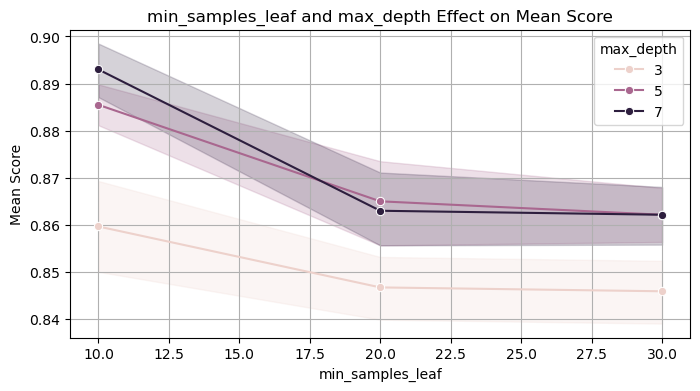

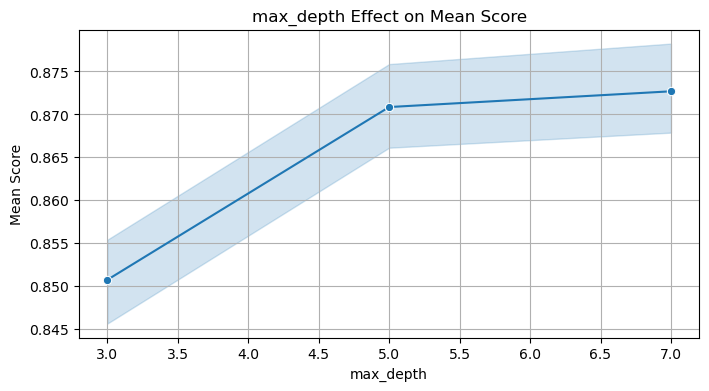

In [10]:
#n_estimators param
plt.figure(figsize=(8, 4))
sns.lineplot(
    x="param_n_estimators",
    y="mean_test_score",
    data=results_df,
    hue="param_max_depth",
    marker="o"
)
plt.title("n_estimators and max_depth Effect on Mean Score")
plt.xlabel("n_estimators")
plt.ylabel("Mean Score")
plt.legend(title="max_depth")
plt.grid(True)
plt.show()

#max_depth
plt.figure(figsize=(8, 4))
sns.lineplot(
    x="param_max_depth",
    y="mean_test_score",
    data=results_df,
    marker="o"
)
plt.title("max_depth Effect on Mean Score")
plt.xlabel("max_depth")
plt.ylabel("Mean Score")
plt.grid(True)
plt.show()

#min_sample_split param
plt.figure(figsize=(8, 4))
sns.lineplot(
    x="param_min_samples_split",
    y="mean_test_score",
    data=results_df,
    hue="param_max_depth",
    marker="o"
)
plt.title("min_samples_split and max_depth Effect on Mean Score")
plt.xlabel("min_samples_split")
plt.ylabel("Mean Score")
plt.legend(title="max_depth")
plt.grid(True)
plt.show()

#min_sample_leaf param
plt.figure(figsize=(8, 4))
sns.lineplot(
    x="param_min_samples_leaf",
    y="mean_test_score",
    data=results_df,
    hue="param_max_depth",
    marker="o"
)
plt.title("min_samples_leaf and max_depth Effect on Mean Score")
plt.xlabel("min_samples_leaf")
plt.ylabel("Mean Score")
plt.legend(title="max_depth")
plt.grid(True)
plt.show()

#max_depth param
plt.figure(figsize=(8, 4))
sns.lineplot(
    x="param_max_depth",
    y="mean_test_score",
    data=results_df,
    marker="o"
)
plt.title("max_depth Effect on Mean Score")
plt.xlabel("max_depth")
plt.ylabel("Mean Score")
plt.grid(True)
plt.show()


# FIT RANDOM FOREST

In [11]:
#train
best_rf.fit(X_train, y_train)

#validation prediction
y_val_pred = best_rf.predict(X_val)

#val accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Validation Accuracy: 92.70%


In [12]:
#val classification report
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        76
           1       0.95      0.94      0.95        66
           2       0.86      0.83      0.85        36

    accuracy                           0.93       178
   macro avg       0.92      0.91      0.91       178
weighted avg       0.93      0.93      0.93       178



In [13]:
#val confusion matrix
print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Validation Confusion Matrix:
[[73  1  2]
 [ 1 62  3]
 [ 4  2 30]]


In [14]:
#cross-validation
model = joblib.load(os.path.join(dfpath, 'notebooks/.pkl_files/best_rf_model_tuned.pkl'))
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores for each fold:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.2f}")
print(f"Standard deviation of cross-validation accuracy: {cv_scores.std():.2f}")

Cross-validation scores for each fold: [0.89655172 0.86956522 0.90434783 0.93913043 0.92173913]
Mean cross-validation accuracy: 0.91
Standard deviation of cross-validation accuracy: 0.02


# TEST SET

In [15]:
# test predict
y_test_pred = best_rf.predict(X_test)

#test evaluate
print("Prediction Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['0', '1', '2',]))
report = classification_report(y_test, y_test_pred, output_dict=True)
cm = confusion_matrix(y_test, y_test_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("\nTest Confusion Matrix:")
print(cm)

Prediction Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        55
           1       0.90      0.92      0.91        39
           2       0.83      0.85      0.84        40

    accuracy                           0.90       134
   macro avg       0.90      0.90      0.90       134
weighted avg       0.90      0.90      0.90       134

Test Accuracy: 90.30%

Test Confusion Matrix:
[[51  0  4]
 [ 0 36  3]
 [ 2  4 34]]


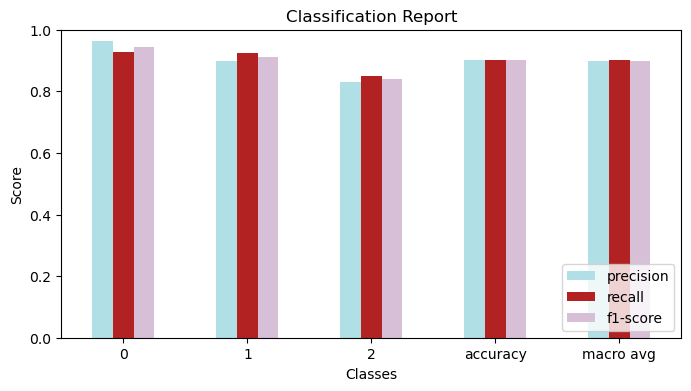

In [16]:
#convert report to DataFrame
report_df = pd.DataFrame(report).transpose()

#plot report
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(
    kind='bar', 
    figsize=(8, 4),
    color=['powderblue', 'firebrick', 'thistle'] )

plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # Adjust the y-axis limit if needed
plt.legend(loc='lower right')
plt.show()

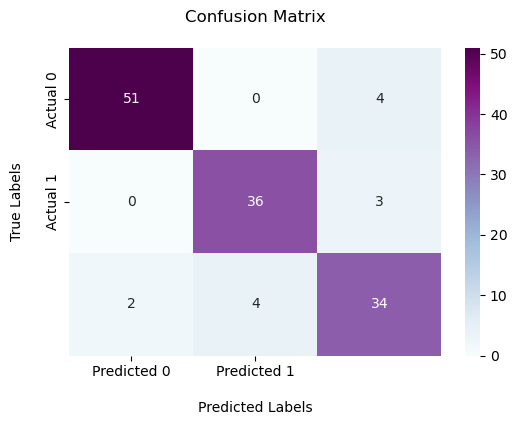

In [22]:
#plot cm
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('\nPredicted Labels')
plt.ylabel('True Labels\n')
plt.title('Confusion Matrix\n')
plt.show()

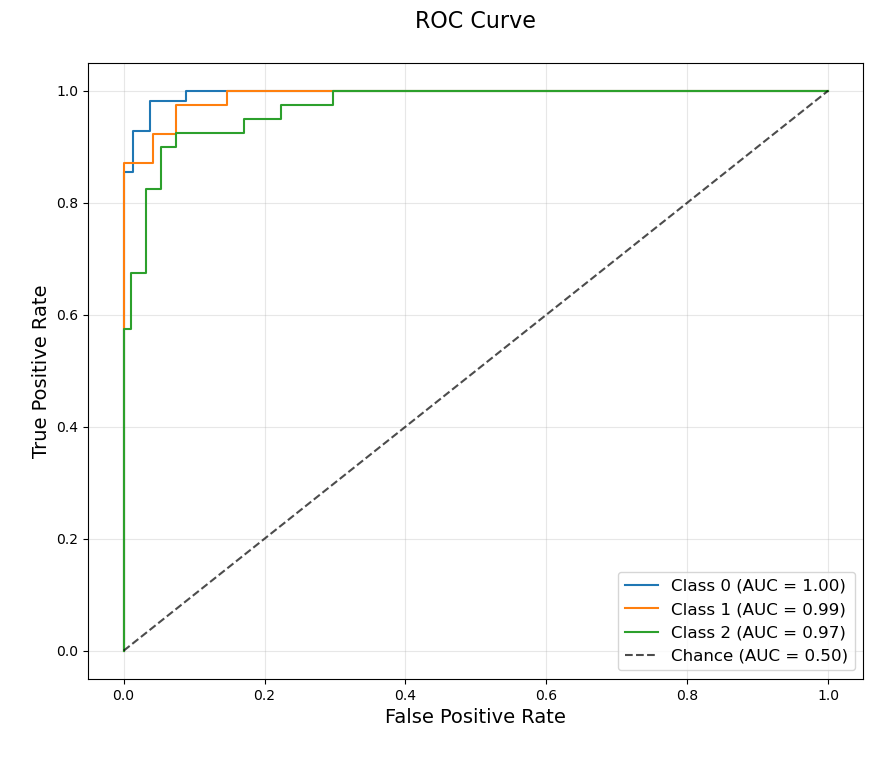

In [ ]:
#binarize output
classes = np.unique(y_test)    #get unique values
y_test_bin = label_binarize(y_test, classes=classes)  #one-hot encoding

#predicted probabilities
y_test_prob = best_rf.predict_proba(X_test)  # Shape: (n_samples, n_classes)

#false positive and true positive rates
flase_pr = {}
true_pr = {}
roc_auc = {}

for i, class_name in enumerate(classes):
    flase_pr[i], true_pr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(flase_pr[i], true_pr[i])

#plot ROC curves
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(classes):
    plt.plot(flase_pr[i], true_pr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)', alpha=0.7)

plt.title('ROC Curve\n', fontsize=16)
plt.xlabel('\nFalse Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate\n', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()
